# Exercices

## **Préliminaires**: Clone de votre repo et imports

In [1]:
# fonctions utiles pour l'ensemble des exercices:
! git clone https://github.com/yumzi41/exam_2025_session2.git
! cp exam_2025_session2/utils/utils.py .
import copy
import numpy as np
import torch
import matplotlib.pyplot as plt
from utils import gen_dr, gen_d, gen_ex2, gen_dr_train,gen_dr_test, voir_batch2D, UNet, make_batch

Cloning into 'exam_2025_session2'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 113 (delta 19), reused 6 (delta 6), pack-reused 75 (from 2)
Receiving objects: 100% (113/113), 2.19 MiB | 5.39 MiB/s, done.
Resolving deltas: 100% (32/32), done.


\

---

\

\

**Exercice 1** *Une segmentation dans un contexte faiblement supervisé*

La fonction *gen_dr* permet de synthétiser des disques mêlés à des rectangles. Ici, les disques sont considérés comme du bruit, et le processus de corruption non en une somme (image = image_disques + image_rectangles) mais en une substitution (voir ci-dessous).
Elle fournit aussi une cible idéale, qui, en pratique, n'est pas disponible.


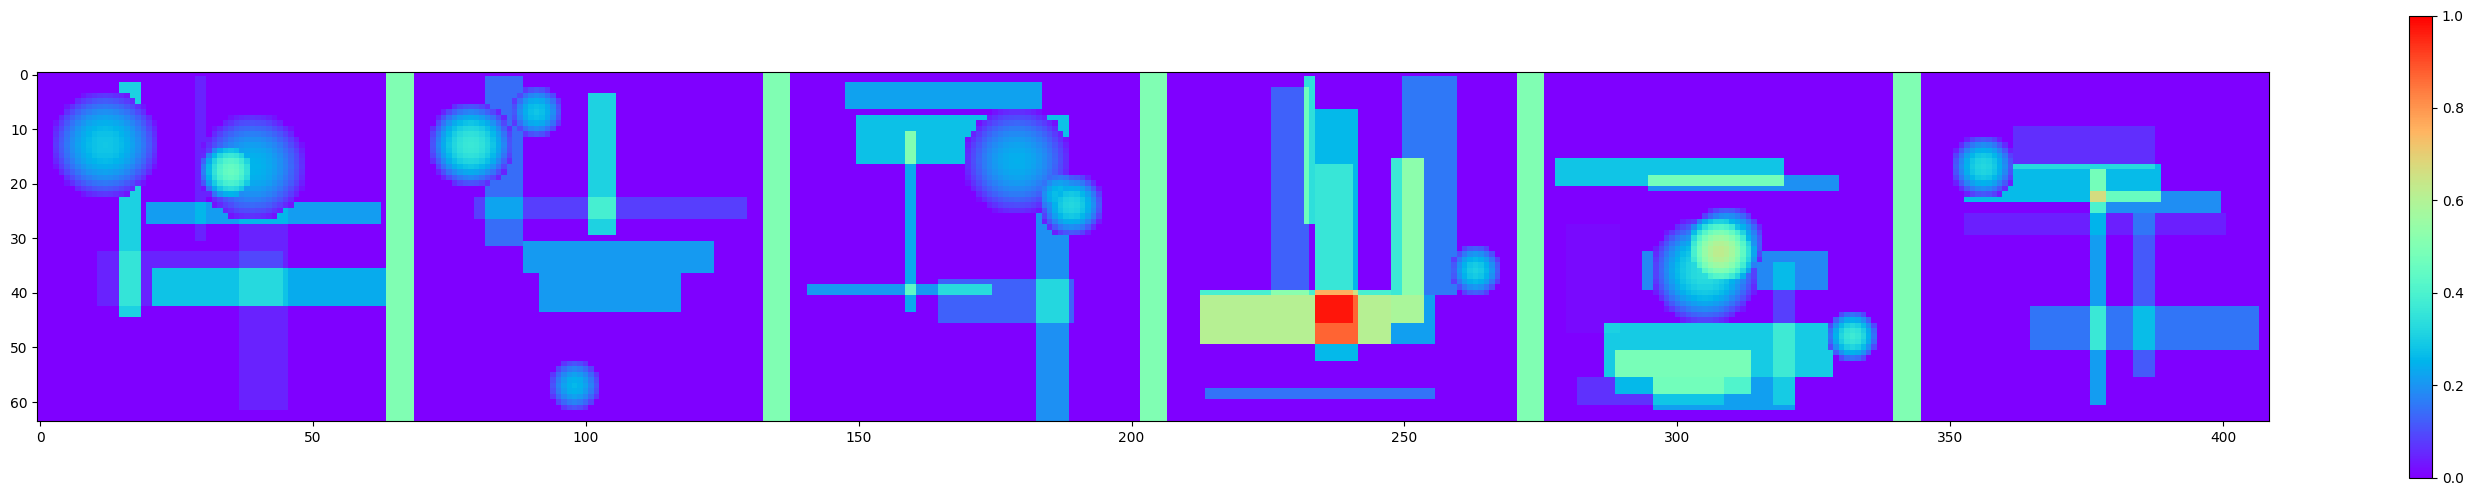

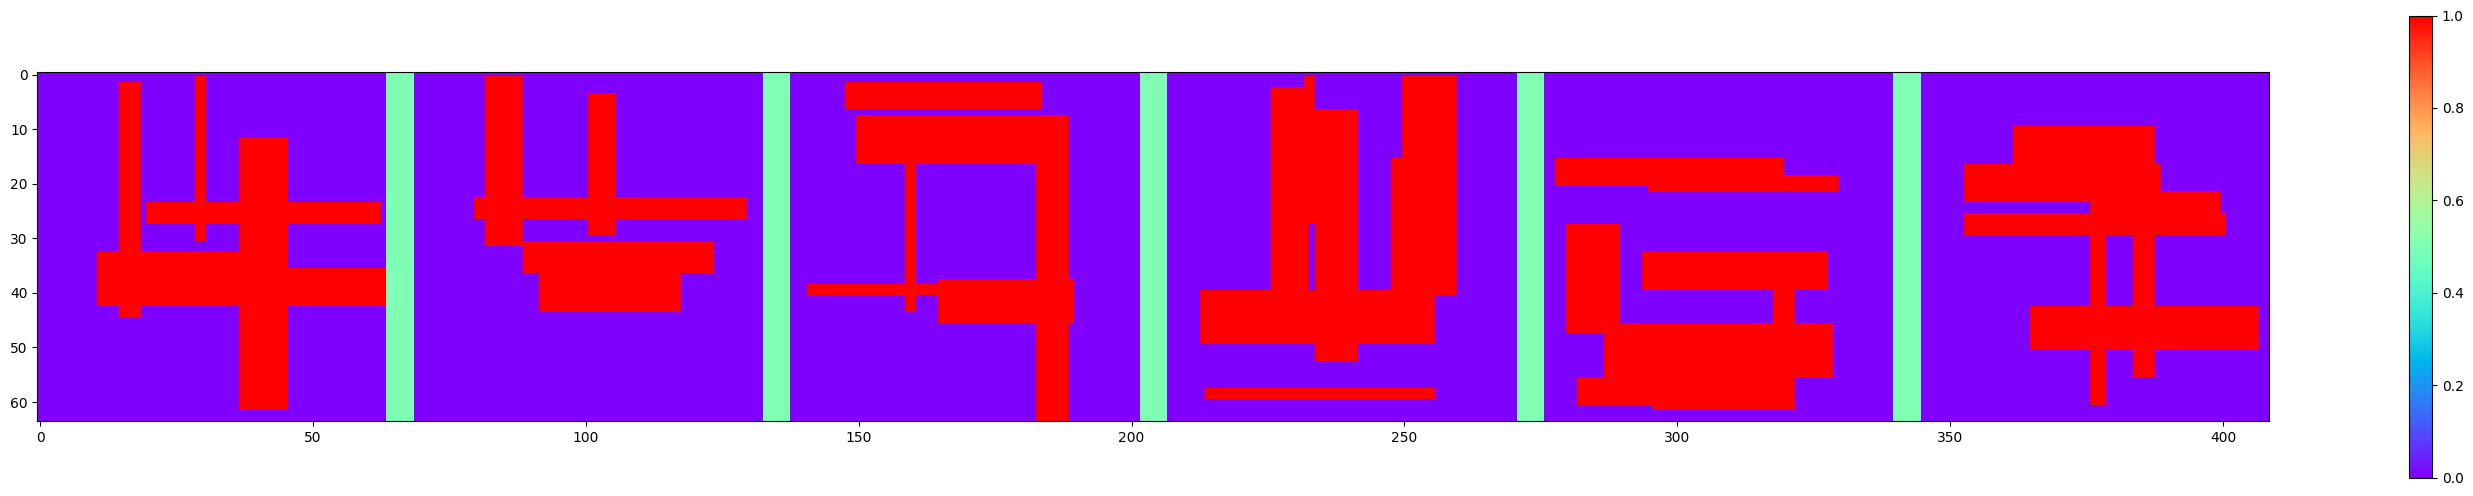

In [3]:
input, ideal_targets = gen_dr(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# ideal targets
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(ideal_targets, 6, fig1, k=0, min_scale=0,max_scale=1)

On dispose aussi d'une fonction *gen_d* qui synthétise des images comportant des disques :

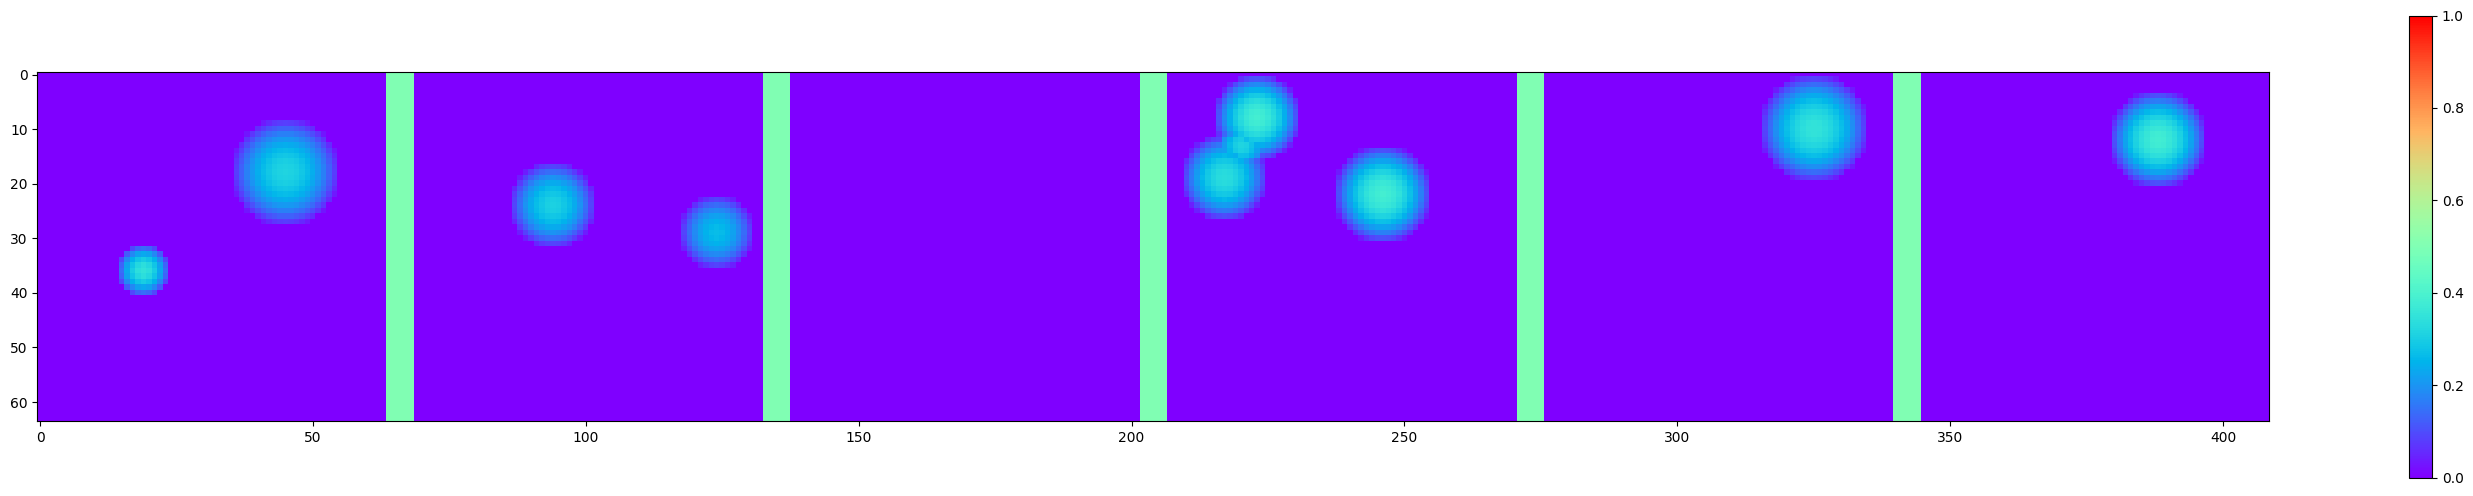

In [4]:
discs = gen_d(6)
# Discs
fig2 = plt.figure(0, figsize=(36, 6))
voir_batch2D(discs, 6, fig2, k=0, min_scale=0,max_scale=1)


**Q1** Rappeler ce qu'est la supervision faible. En quoi ce problème peut-il entrer dans cette catégorie ?

Une supervision faible signifie que les annotations ne sont pas exhaustives, mais restent suffisamment informatives pour permettre l'entraînement. Par exemple, dans notre cas, la target idéale se limite à deux valeurs : nous ne disposons pas d'informations sur la couleur réelle du rectangle, mais uniquement de l'empreinte (ou "ombre") issue de l'image débruitée.

**Q2** Utiliser un UNet pour dire, pour une image produite par gen_dr, où sont les pixels qui étaient affectés par des rectangles **avant** corruption. Entraînez-le sur une cinquantaine d'époques. Utilisez la cible idéale pour contrôler la convergence. Visualiser quelques sorties après entraînement. Commentez.

In [5]:
def ABSOLUTE_LOSS(y_pred, y_true):
    return torch.abs(y_pred - y_true).mean()

In [7]:
def BCE_LOSS(y_pred, y_true):
    return torch.nn.functional.binary_cross_entropy(y_pred, y_true)

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import copy
import numpy as np
from sklearn.metrics import f1_score

# On suppose que les fonctions gen_dr, gen_d et le modèle UNet sont déjà définis ailleurs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_channels=1, n_classes=2, size=64).to(device)
criterion = nn.CrossEntropyLoss()  # Loss prédéfinie
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 50
batch_size = 64

# --- Entraînement ---
for epoch in range(epochs):
    model.train()

    # Génération des données d'entraînement
    rect_img, ideal_targets = gen_dr(batch_size)  # shape : [batch_size, 1, 64, 64]
    discs = gen_d(batch_size)                       # shape : [batch_size, 1, 64, 64]

    # Préparation de la cible imparfaite (on garde uniquement 0 ou 1)
    targets = copy.deepcopy(rect_img)
    targets[targets > 0] = 1
    targets[targets <= 0] = 0
    # Suppression du canal pour obtenir un tenseur de shape [batch_size, 64, 64]
    targets = np.squeeze(targets, axis=1)

    # Préparation des entrées corrompues (on combine rect_img et discs)
    inputs = copy.deepcopy(rect_img)
    inputs[discs > 0] = discs[discs > 0]

    # Conversion en tenseurs et envoi sur le device
    train_inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
    train_targets = torch.tensor(targets, dtype=torch.long).to(device)
    ideal_targets = torch.tensor(ideal_targets, dtype=torch.float32).to(device)

    # Passage avant, calcul de la loss et rétropropagation
    outputs = model(train_inputs)  # shape : [batch_size, 2, 64, 64]
    loss = criterion(outputs, ideal_targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print("Epoch [{}/{}], Loss: {:.4f}".format(epoch+1, epochs, loss.item()))

    preds = torch.argmax(outputs, dim=1).unsqueeze(1)  # shape : [batch_size, 1, 64, 64]
    preds_np = preds.cpu().numpy()

    # Si ideal_targets est déjà un tenseur PyTorch, on utilise clone().detach()
    ideal_targets_tensor = ideal_targets.clone().detach().to(device, dtype=torch.long)
    if epoch % 10 == 0:
          # --- Évaluation ---
      model.eval()
      with torch.no_grad():
          f1 = f1_score(ideal_targets_tensor.cpu().numpy().flatten(),
                      preds.cpu().numpy().flatten(), average='macro')
          print("F1 Score: {:.4f}".format(f1))
          # --- Évaluation et affichage ---
      for i in range(1):
          plt.figure(figsize=(20, 5))

          plt.subplot(1, 5, 1)
          plt.title("Image d'entrée\n(corrompue)")
          plt.imshow(inputs[i, 0].cpu().numpy(), cmap='gray')
          plt.axis('off')

          plt.subplot(1, 5, 2)
          plt.title("Image originale\n(rect_img)")
          plt.imshow(rect_img[i, 0, :, :], cmap='gray')
          plt.axis('off')

          plt.subplot(1, 5, 3)
          plt.title("Cible idéale")
          plt.imshow(ideal_targets[i, 0, :, :], cmap='gray')
          plt.axis('off')

          plt.subplot(1, 5, 4)
          plt.title("Cible imparfaite")
          plt.imshow(targets[i, :, :], cmap='gray')
          plt.axis('off')

          plt.subplot(1, 5, 5)
          plt.title("Prédiction (classes)")
          plt.imshow(preds_np[i, 0, :, :], cmap='gray')
          plt.axis('off')

          plt.show()




<ipython-input-56-1fcb59933b7e>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
<ipython-input-56-1fcb59933b7e>:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_targets = torch.tensor(targets, dtype=torch.long).to(device)
<ipython-input-56-1fcb59933b7e>:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ideal_targets = torch.tensor(ideal_targets, dtype=torch.float32).to(device)


OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 8.12 MiB is free. Process 4562 has 14.73 GiB memory in use. Of the allocated memory 14.56 GiB is allocated by PyTorch, and 45.72 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

<ipython-input-51-ecf9dd91eae6>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
<ipython-input-51-ecf9dd91eae6>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ideal_targets_tensor = torch.tensor(ideal_targets, dtype=torch.long).to(device)


F1 Score (macro): 0.2978


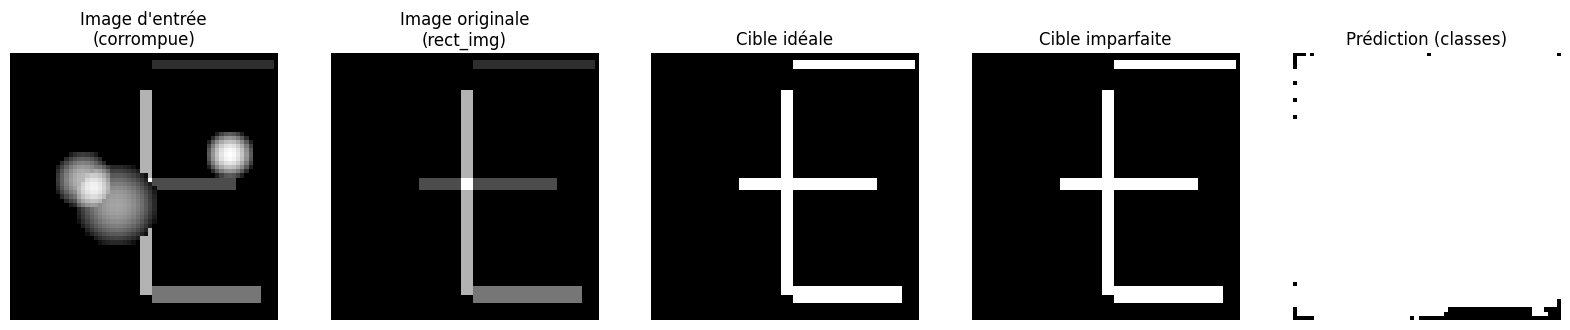

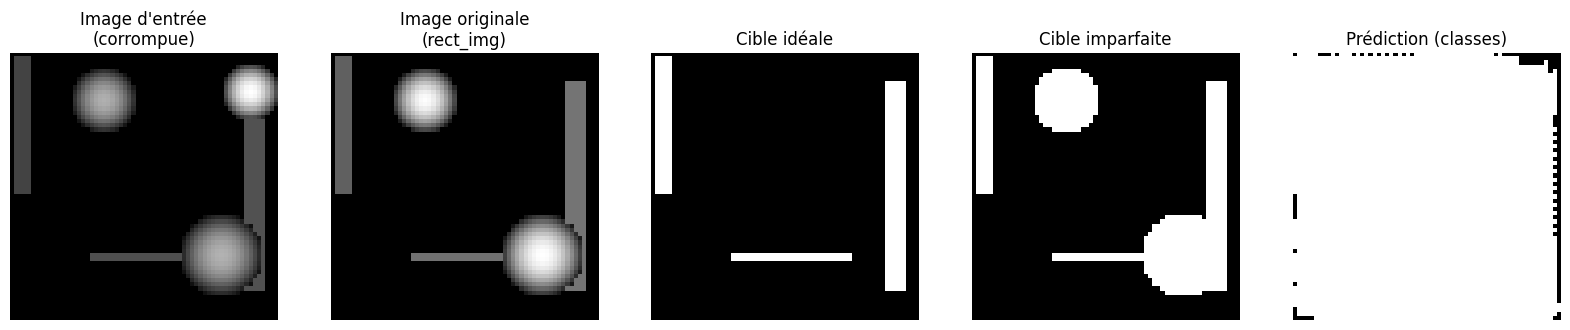

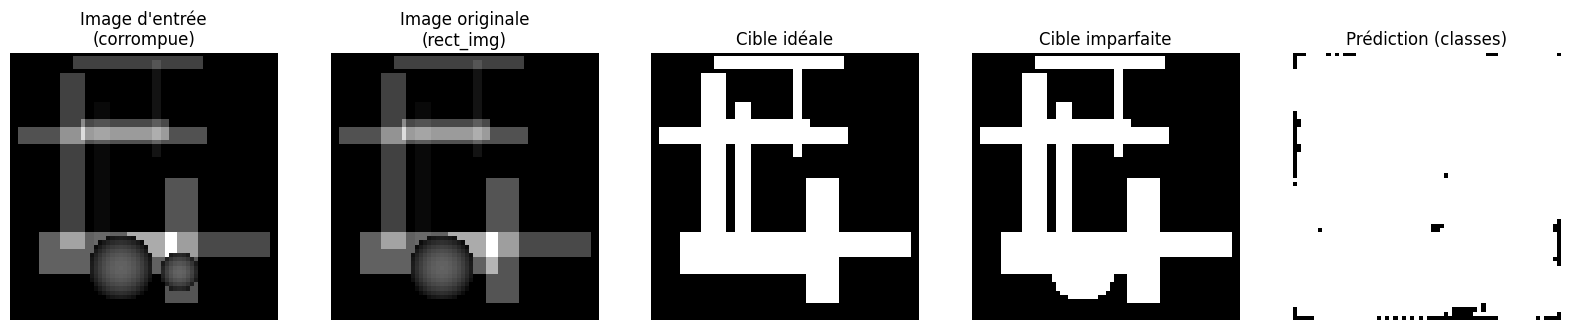

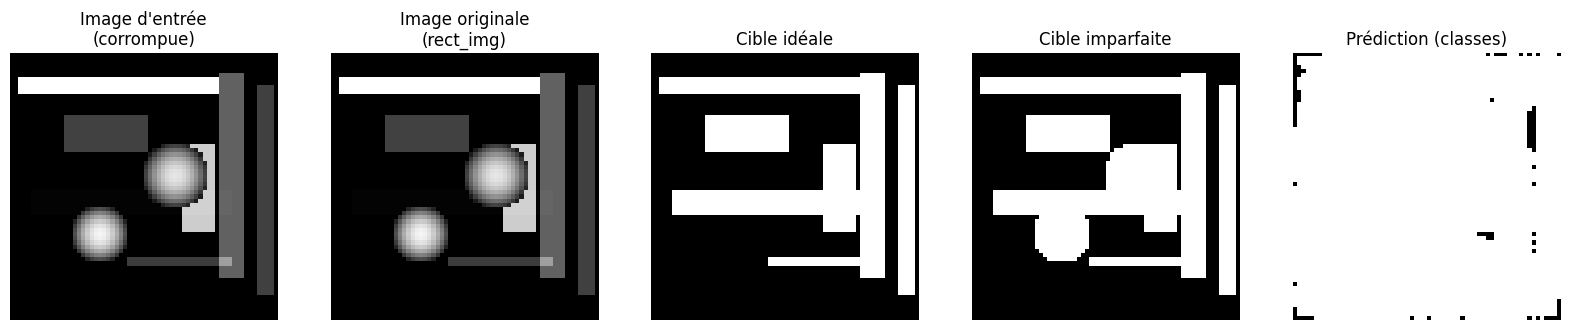

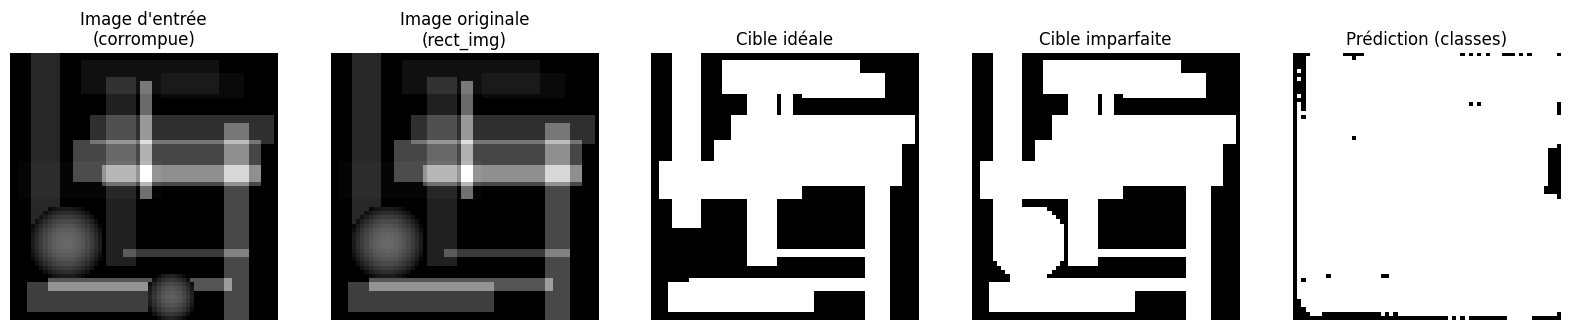

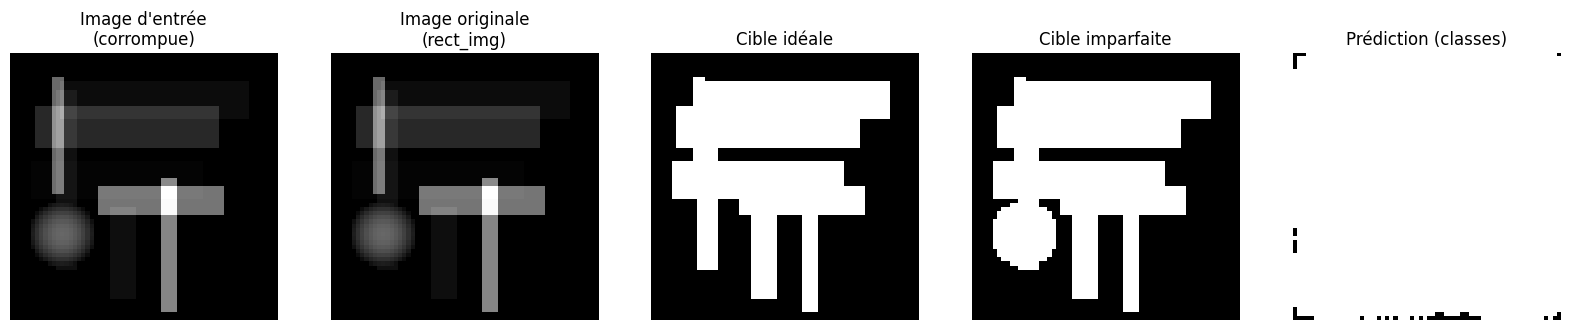

In [51]:
from sklearn.metrics import f1_score

model.eval()
with torch.no_grad():
    rect_img, ideal_targets = gen_dr(batch_size)
    discs = gen_d(batch_size)

    targets = copy.deepcopy(rect_img)
    targets[targets > 0] = 1
    targets[targets <= 0] = 0

    inputs = copy.deepcopy(rect_img)
    inputs[discs > 0] = discs[discs > 0]

    test_inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
    outputs = model(test_inputs)

    preds = torch.argmax(outputs, dim=1).unsqueeze(1)
    preds_np = preds.cpu().numpy()

    # Conversion de ideal_targets en tenseur et suppression du canal
    ideal_targets_tensor = torch.tensor(ideal_targets, dtype=torch.long).to(device)
    ideal_targets_tensor = ideal_targets_tensor.squeeze(1)

    # Calcul du F1 score entre la prédiction et la cible idéale
    f1 = f1_score(ideal_targets_tensor.cpu().numpy().flatten(),
                  preds.cpu().numpy().flatten(), average='macro')
    print("F1 Score (macro): {:.4f}".format(f1))

for i in range(6):
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 5, 1)
    plt.title("Image d'entrée\n(corrompue)")
    plt.imshow(test_inputs[i, 0].cpu().numpy(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.title("Image originale\n(rect_img)")
    plt.imshow(rect_img[i, 0, :, :], cmap='gray')
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.title("Cible idéale")
    plt.imshow(ideal_targets[i, 0, :, :], cmap='gray')
    plt.axis('off')

    plt.subplot(1, 5, 4)
    plt.title("Cible imparfaite")
    plt.imshow(targets[i, 0, :, :], cmap='gray')
    plt.axis('off')

    plt.subplot(1, 5, 5)
    plt.title("Prédiction (classes)")
    plt.imshow(preds_np[i, 0, :, :], cmap='gray')
    plt.axis('off')

    plt.show()


Je ne comprends pas pourquoi le test donne ces résultats...

\

**Exercice 2** *Une régression quantile*

La fonction *gen_ex2* permet de synthétiser des entrées / cibles à la volée :  




tensor([4.5667, 0.5015, 2.4071, 3.7355, 4.1199, 7.1115])


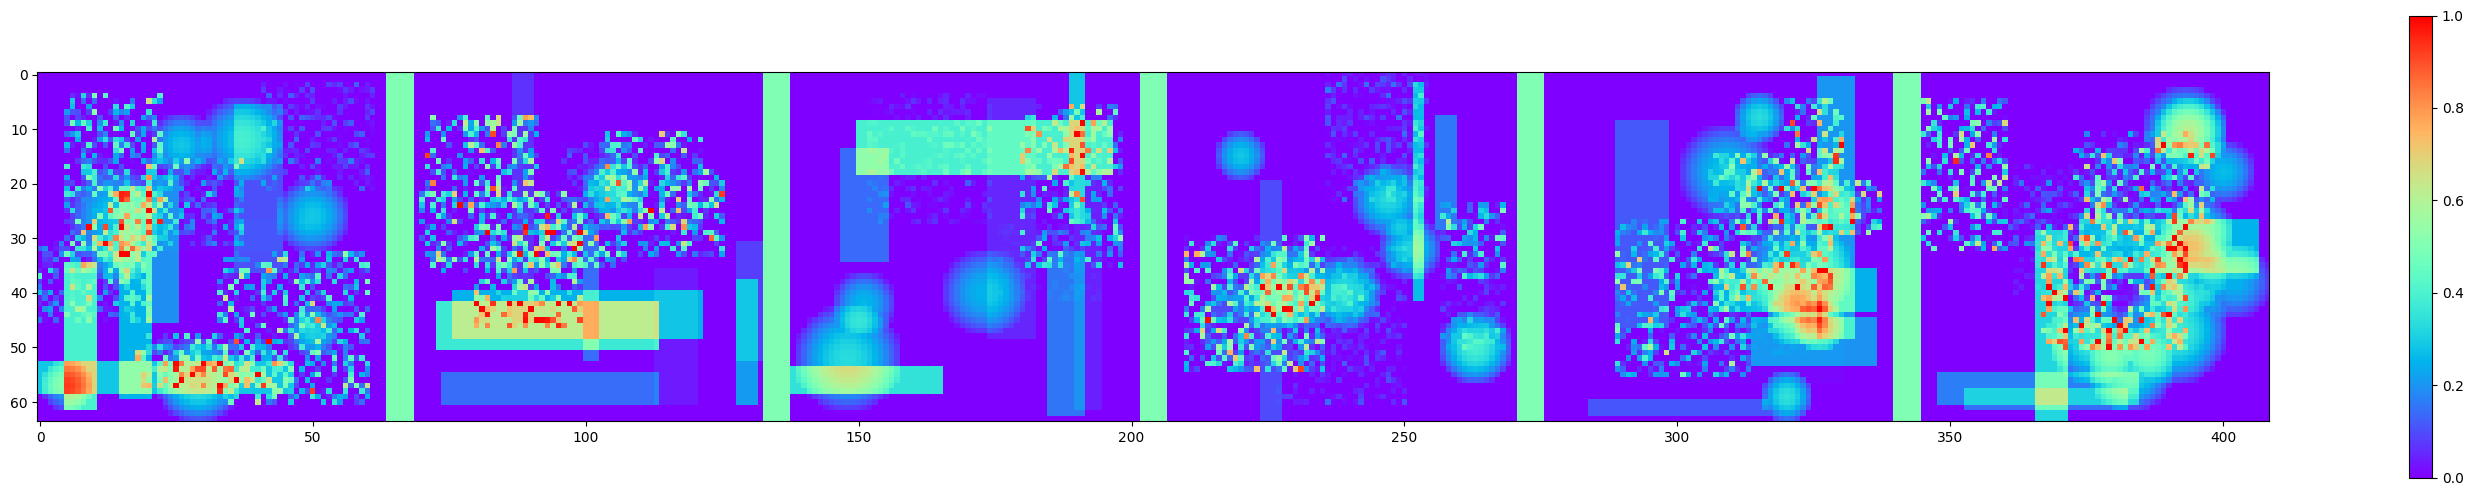

tensor([4.4929, 0.3332, 0.7569, 5.1440, 6.0943, 7.8501])


In [ ]:
# sampling (x,y) :

inputs, targets = gen_ex2(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(inputs, 6, fig0, k=0, min_scale=0,max_scale=1)

# Targets
print(targets)

**Q1** Définir un Loader à partir du Dataset précédent (2 workers)

In [ ]:
from torch.utils.data import Dataset, DataLoader

class Ex2Dataset(Dataset):
    def __init__(self, n_samples, transform=None):
        self.inputs, self.targets = gen_ex2(n_samples)
        self.transform = transform

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        x = np.array(self.inputs[idx], dtype=np.float32)
        y = np.array(self.targets[idx], dtype=np.float32)
        if self.transform:
            x = self.transform(x)
        return x, y

dataset = Ex2Dataset(1000)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)


tensor([ 3.2754,  0.9384,  6.1758,  4.0438,  4.8179,  3.2340,  2.7188,  8.2257,
         6.6533,  4.3748,  1.9466,  1.9794,  2.0179,  2.6841,  4.0982,  3.8575,
         3.5612,  7.6891,  5.2843,  8.3179,  4.0767,  4.7845,  1.8180,  2.5029,
         6.3265,  2.0810,  6.4127,  5.9331,  5.5151,  6.2094,  5.1111,  2.9846,
         7.0910,  8.2645,  4.4430,  0.8618,  4.5330,  2.7266,  2.7579,  6.3773,
         3.7376,  7.6654,  3.2596,  7.9496,  9.5783,  4.7744,  3.6927,  3.2763,
         2.1761,  4.0824,  6.8070,  7.8180,  4.6381,  3.6722,  4.2818,  7.0426,
         5.3746,  1.9069,  3.9071,  6.5770,  6.4035,  3.0071,  4.2707,  2.2557,
         3.9131,  6.0110,  6.1576,  4.2767,  0.7956,  1.7066,  4.9964, 11.1951,
         3.7670,  3.5200,  3.2516,  2.7430,  8.4107,  6.4592,  1.5139,  4.7122,
         3.2366,  6.9837,  2.5124,  2.4799,  4.4044,  7.0831,  4.5390,  0.2980,
         3.6048,  4.5152,  7.7040,  3.3235,  5.6491,  6.8195,  3.5005,  4.2927,
         5.9618,  2.0440,  4.5107,  6.50

**Q2** Entraîner un ResNet18 à prédire la médiane conditionnelle à l'image d'entrée. Justifier l'absence d'une étape de validation.

In [ ]:
from torchvision.models import resnet18

...

Ellipsis

**Q3** Modifier votre ResNet18 de manière à prédire aussi les premier et troisième quartiles. Préciser le nom de la fonction de coût utilisée.

**Q4** Après entraînement, évaluer les écarts interquartiles sur un batch de taille 64. Ces écarts semblent-ils dépendre de l'image d'entrée ?

**Q5 (Bonus)** On fait l'hypothèse que la sortie ne dépend que des disques. On suppose aussi qu'on ait accès, comme à l'exercice 1 à un jeu de données d'images ne comportant que des disques (fonction gen_d). Que feriez-vous pour tester cette hypothèse ? Répondez sans code, mais avec précision.

\

---

\

**Exercice 3** *Nettoyage et adaptation de domaine*

Comme à l'exercice 1, les disques sont considérés comme du bruit. Mais par contre, il s'agit d'une tâche de nettoyage et on se place dans le cas où des entrées et des cibles idéales sont disponibles en grand nombre à l'entraînement (fonction *gen_dr_train*).

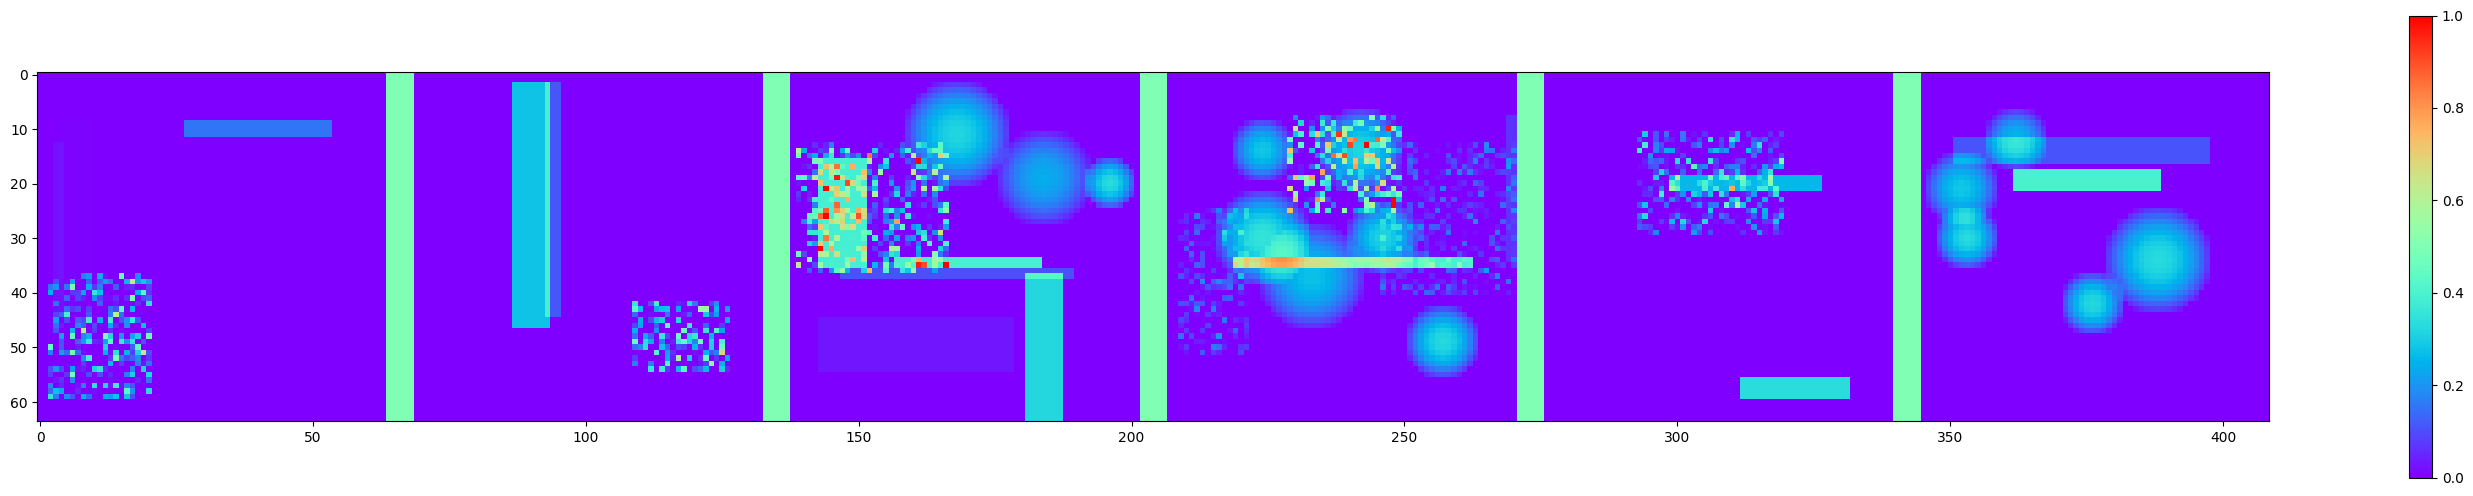

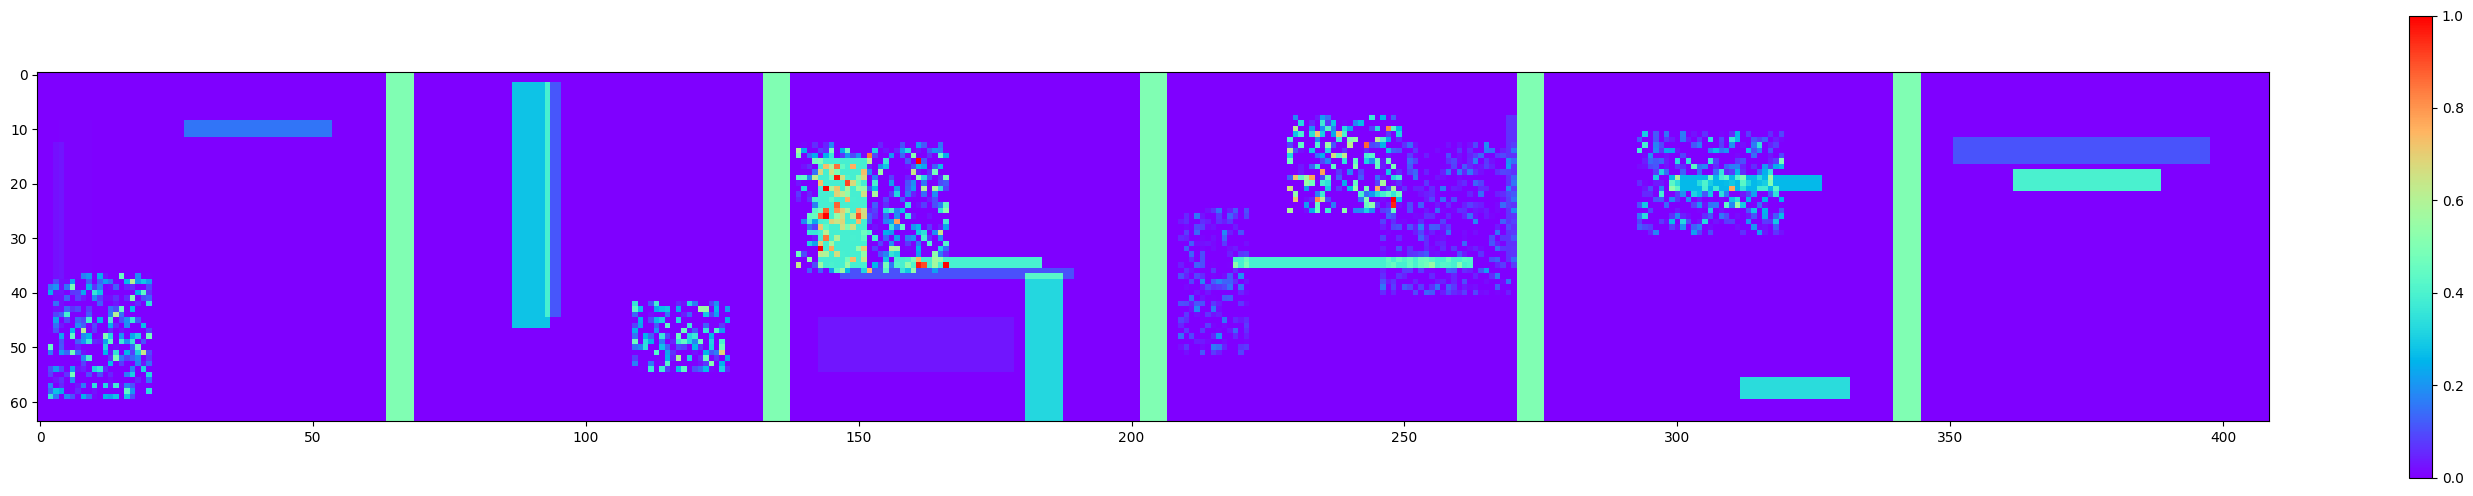

In [ ]:
input, targets = gen_dr_train(6)
# Inputs (train)
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# targets (train)
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(targets, 6, fig1, k=0, min_scale=0,max_scale=1)

Par contre, on suppose que les images disponibles à l'entraînement ne suivent pas les mêmes statistiques que les données test, échantillonnables avec la fonction gen_dr_test suivante :

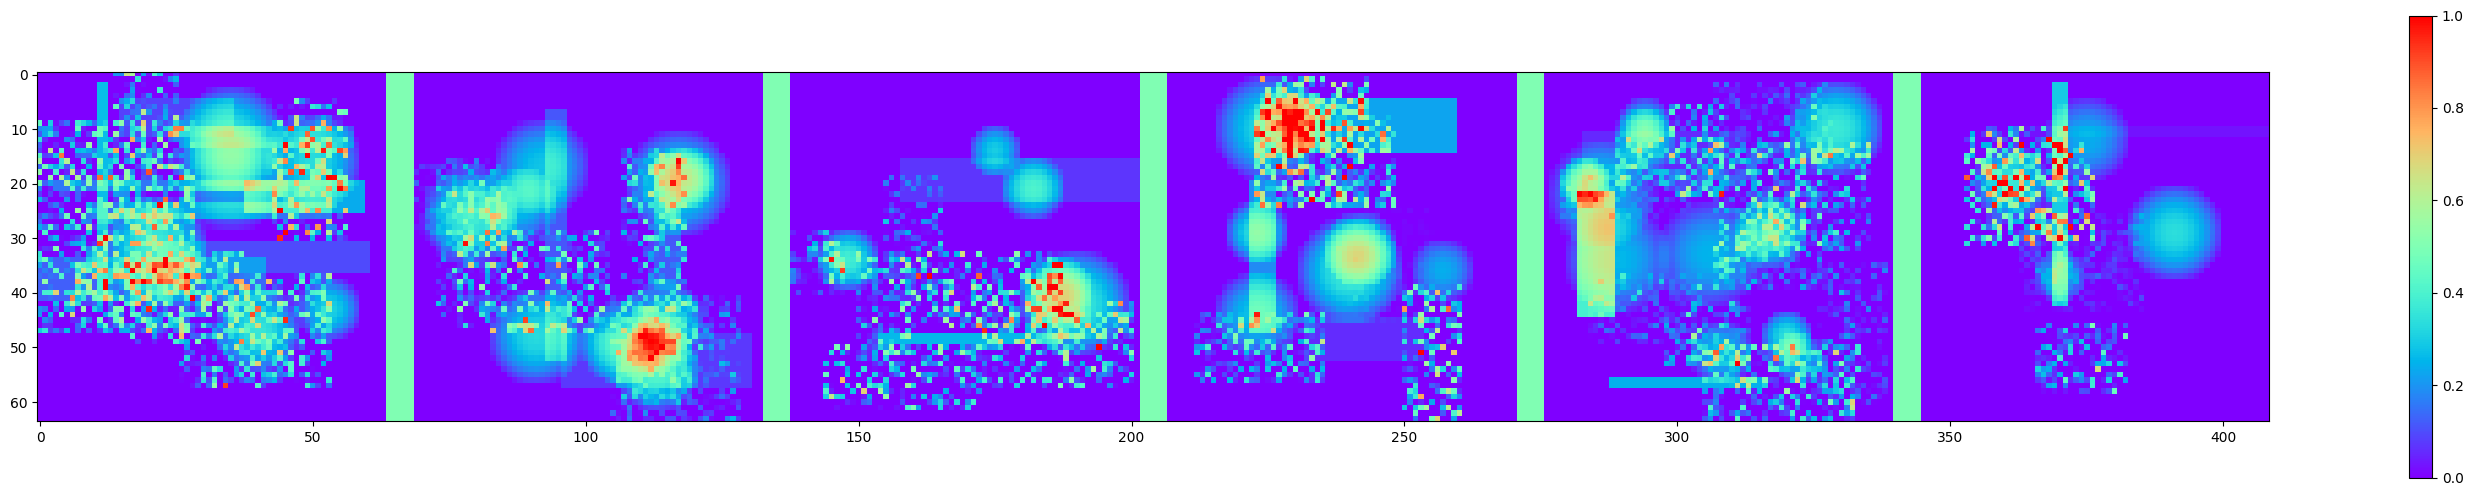

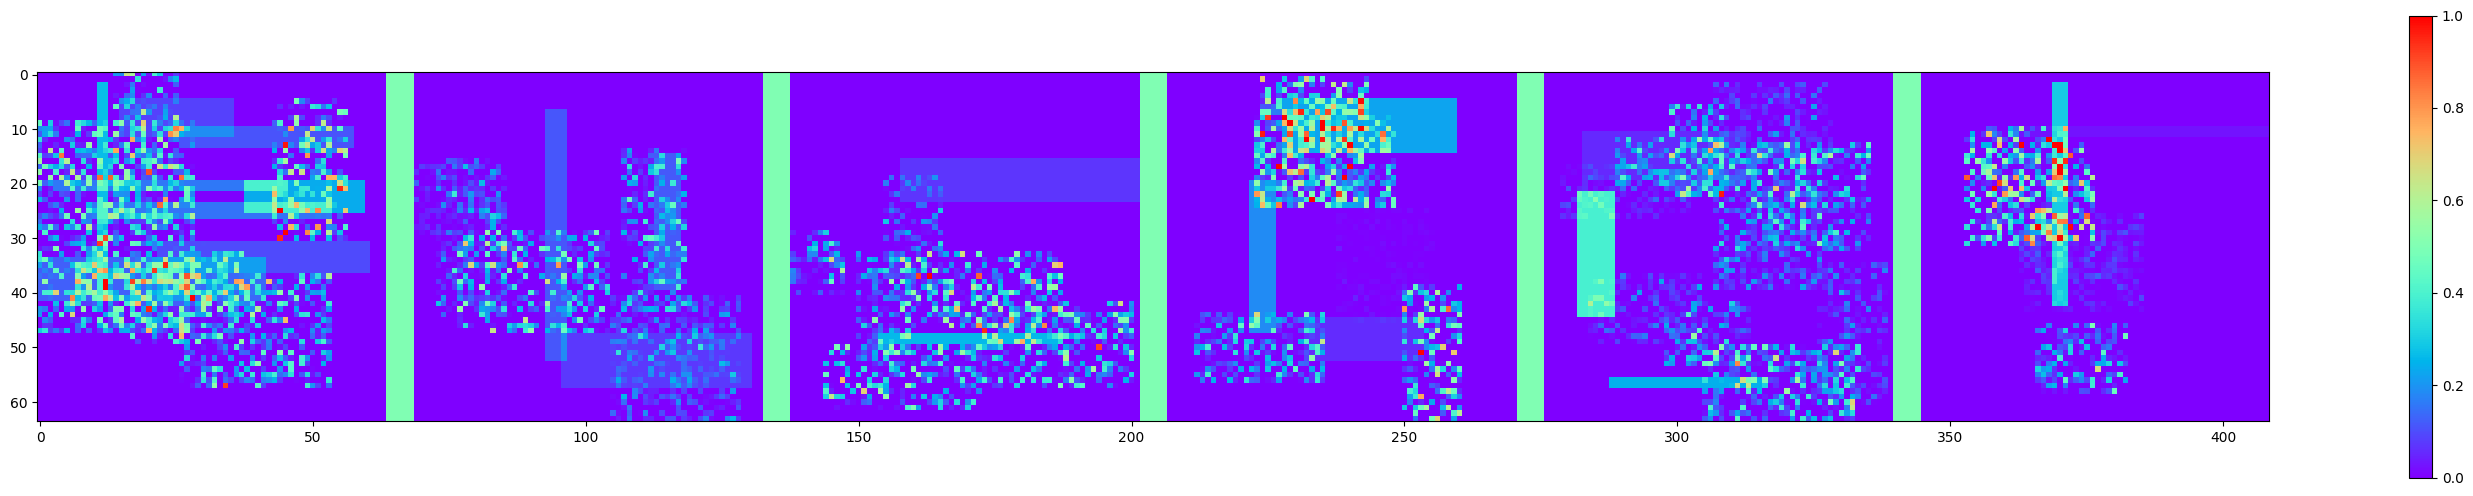

In [ ]:
input, targets = gen_dr_test(6)
# Inputs (test)
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# targets (test)
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(targets, 6, fig1, k=0, min_scale=0,max_scale=1)

Ce qu'on voit en effet, c'est que les images test sont plus chargées en figures géométriques. \
Dans la réalité, ce cas de figure se présente lorsque :
 - les données propres au test (ie, représentatives des données à traiter en inférence) sont en trop petit nombre pour être exploitées à l'entraînement
 - un large jeu de données dont les statistiques sont différentes de celles des données d'inférence est disponible.

**Q1** A l'aide d'internet, décrire ce que recouvre le mot clef "domain adaptation" et faites le lien avec l'énoncé.

Le "domain adaptation" est une technique de transfert d’apprentissage où un modèle entraîné sur un domaine source est adapté pour fonctionner sur un domaine cible ayant une distribution différente. Dans l’énoncé, le modèle est entraîné sur un dataset contenant un équilibre entre cercles et carrés, mais testé sur un dataset avec une distribution différente (plus de cercles et de carrés). Cela illustre un changement de distribution des données entre l'entraînement et le test, ce qui peut dégrader la performance du modèle s'il n'est pas capable de généraliser. Des techniques de domain adaptation comme l’apprentissage adversarial ou la normalisation des caractéristiques peuvent être utilisées pour améliorer la robustesse du modèle.

**Q2** Sur des entraînements courts (20 - 40 époques) avec des UNet, évaluer l'impact sur les performances sur le jeu de test lorsque les données sont entraînées avec gen_dr_train plutôt que dans une situation idéale.

In [ ]:
epochs = 30
batch_size = 64
learning_rate = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_channels=1, n_classes=1, size=64).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

for epoch in range(epochs):
    model.train()
    inputs, targets = gen_dr_train(batch_size)
    inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
    targets = torch.tensor(targets, dtype=torch.float32).to(device)

    outputs = model(inputs)
    loss = loss_fn(outputs, targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f}")
    del inputs, targets, outputs


<ipython-input-31-30a19f9358d0>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
<ipython-input-31-30a19f9358d0>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32).to(device)


Epoch 1/30 - Loss: 0.1414
Epoch 2/30 - Loss: 0.1003
Epoch 3/30 - Loss: 0.0827
Epoch 4/30 - Loss: 0.0641
Epoch 5/30 - Loss: 0.0532
Epoch 6/30 - Loss: 0.0467
Epoch 7/30 - Loss: 0.0423
Epoch 8/30 - Loss: 0.0425
Epoch 9/30 - Loss: 0.0373
Epoch 10/30 - Loss: 0.0318
Epoch 11/30 - Loss: 0.0284
Epoch 12/30 - Loss: 0.0263
Epoch 13/30 - Loss: 0.0261
Epoch 14/30 - Loss: 0.0242
Epoch 15/30 - Loss: 0.0220
Epoch 16/30 - Loss: 0.0183
Epoch 17/30 - Loss: 0.0179
Epoch 18/30 - Loss: 0.0185
Epoch 19/30 - Loss: 0.0168
Epoch 20/30 - Loss: 0.0156
Epoch 21/30 - Loss: 0.0158
Epoch 22/30 - Loss: 0.0144
Epoch 23/30 - Loss: 0.0130
Epoch 24/30 - Loss: 0.0134
Epoch 25/30 - Loss: 0.0126
Epoch 26/30 - Loss: 0.0117
Epoch 27/30 - Loss: 0.0115
Epoch 28/30 - Loss: 0.0112
Epoch 29/30 - Loss: 0.0108
Epoch 30/30 - Loss: 0.0106


torch.Size([6, 1, 64, 64])


<ipython-input-32-1453ff43d088>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_inputs_tensor = torch.tensor(test_inputs, dtype=torch.float32).to(device)


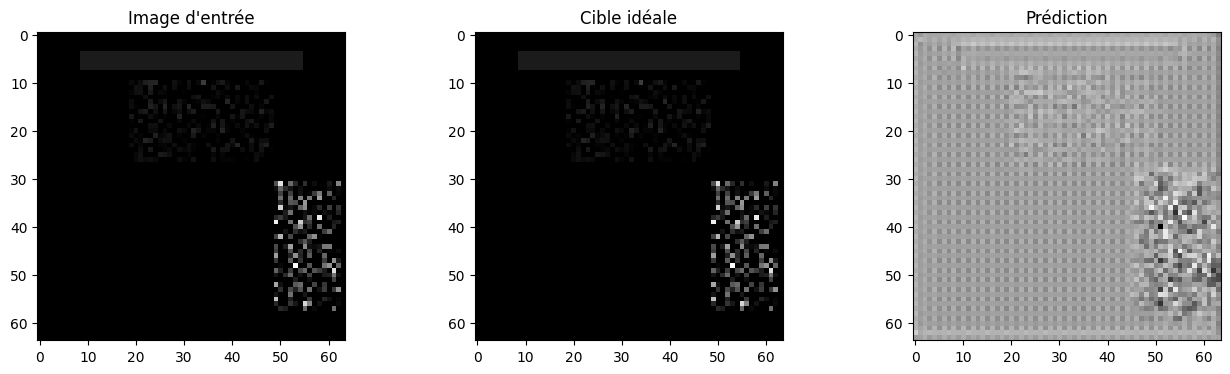

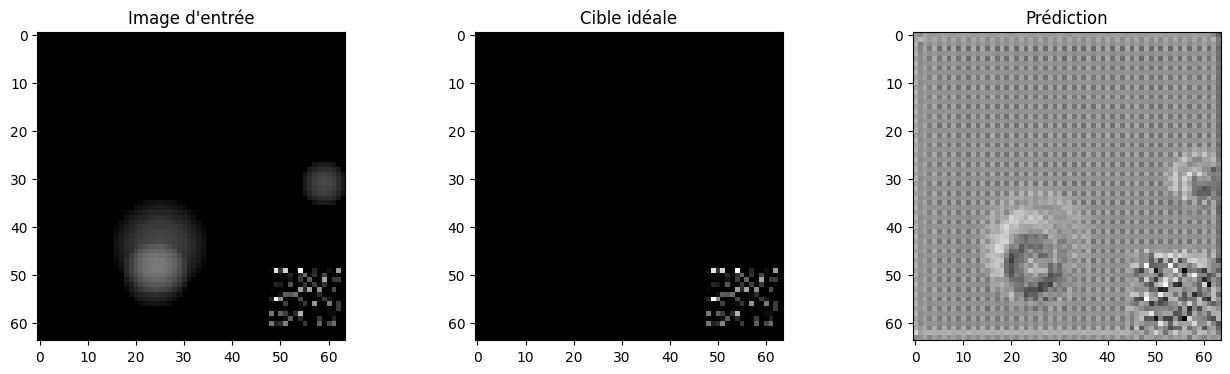

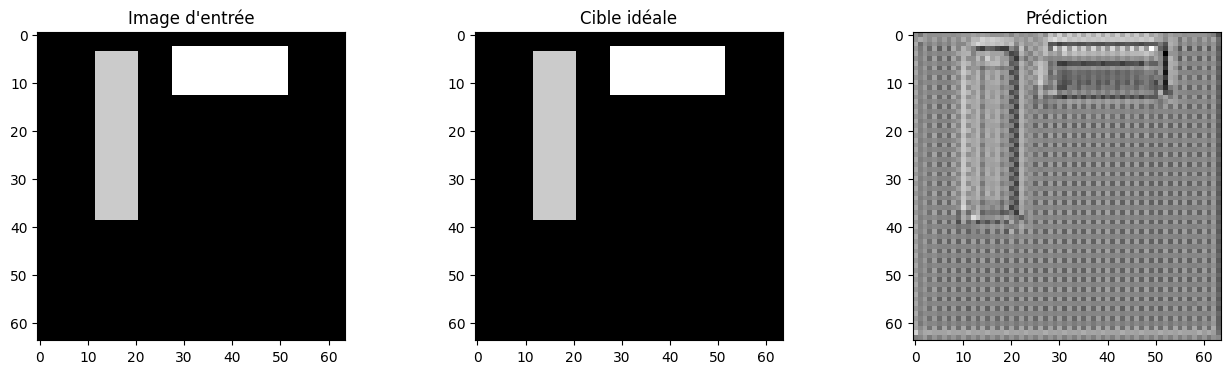

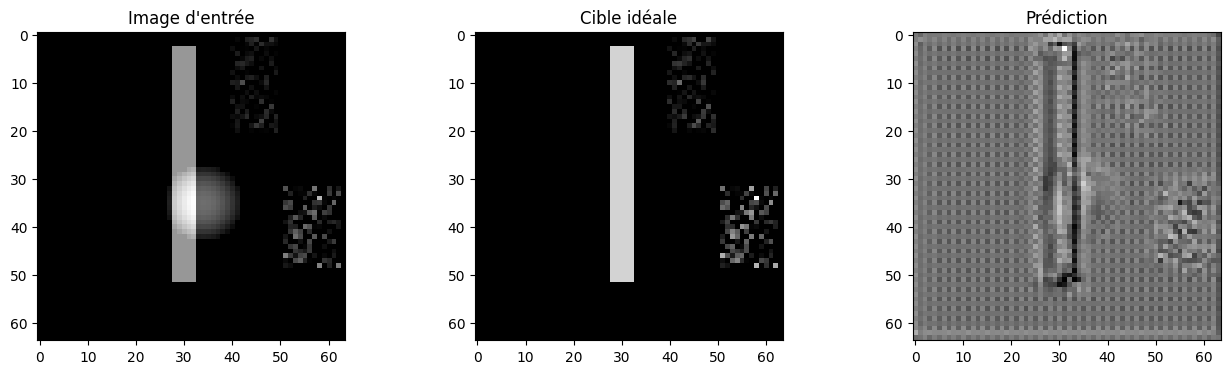

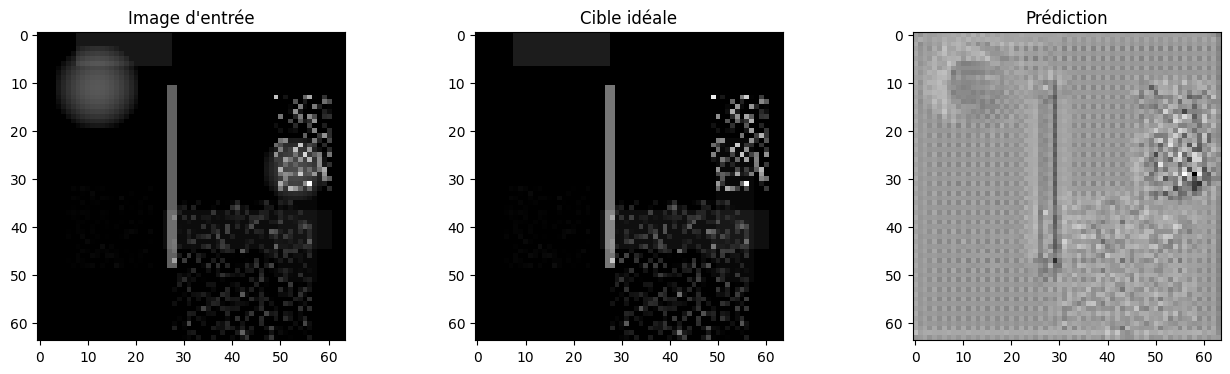

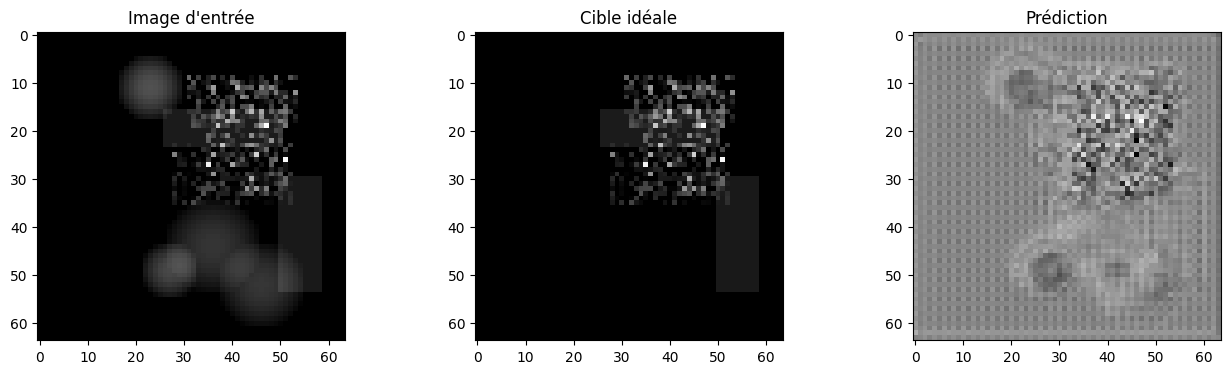

In [ ]:
model.eval()
with torch.no_grad():
    test_inputs, test_targets = gen_dr_train(6)
    test_inputs_tensor = torch.tensor(test_inputs, dtype=torch.float32).to(device)
    predictions = model(test_inputs_tensor)
    print(predictions.shape)

for i in range(6):
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 3, 1)
    plt.title("Image d'entrée")
    plt.imshow(test_inputs[i, 0, :, :], cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title("Cible idéale")
    plt.imshow(test_targets[i, 0, :, :], cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Prédiction")
    plt.imshow(predictions[i, 0].cpu().numpy(), cmap='gray')

    plt.show()

<ipython-input-33-d5c50fda9c1d>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_inputs_tensor = torch.tensor(test_inputs, dtype=torch.float32).to(device)


torch.Size([6, 1, 64, 64])


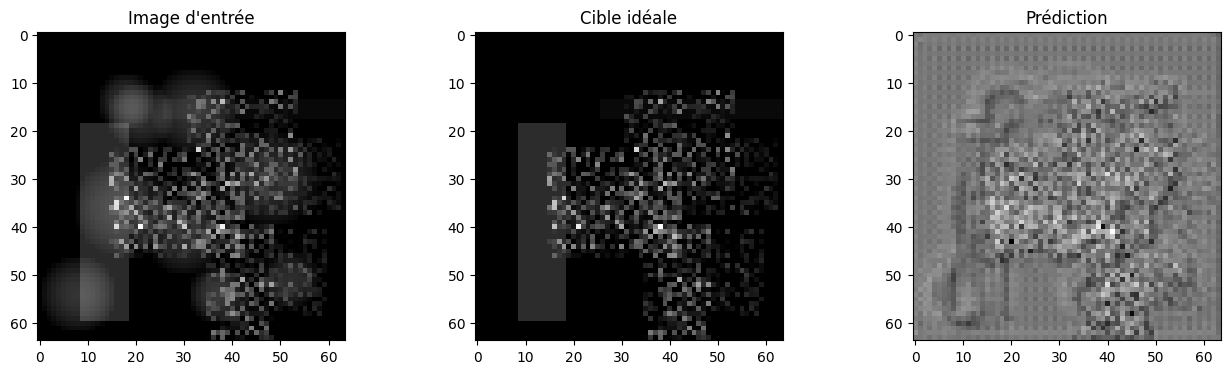

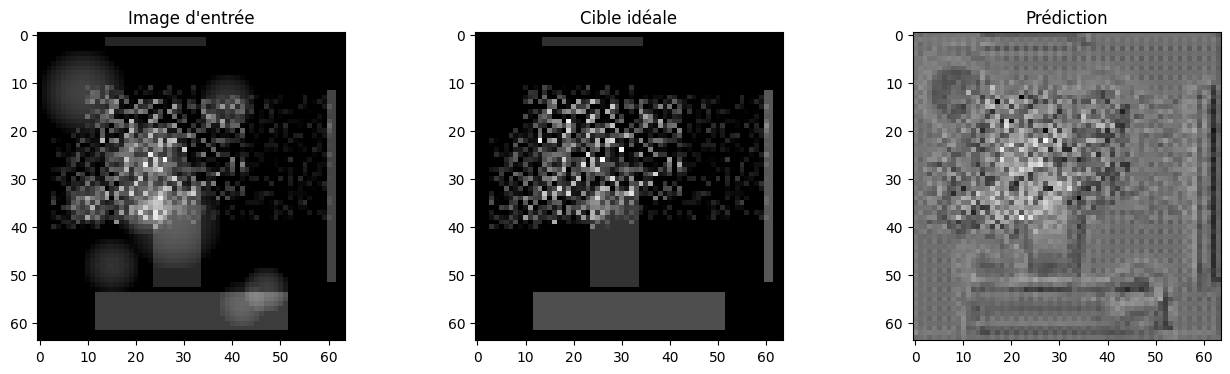

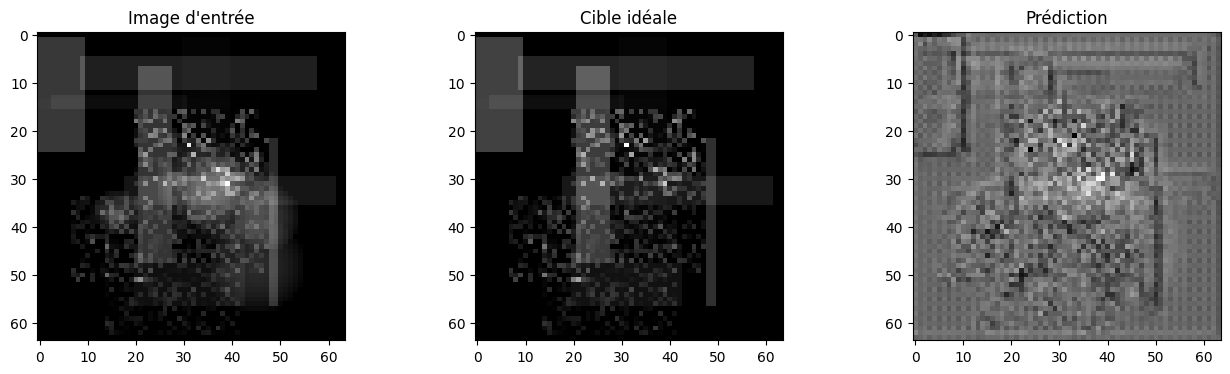

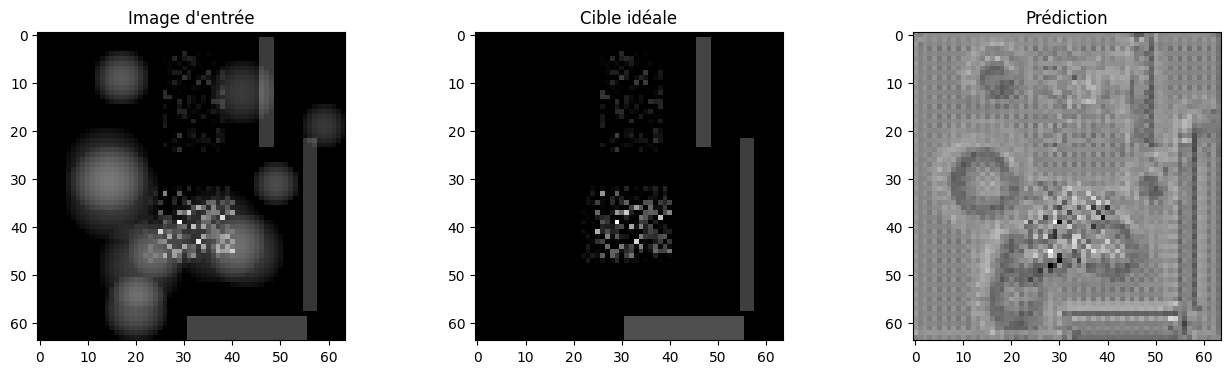

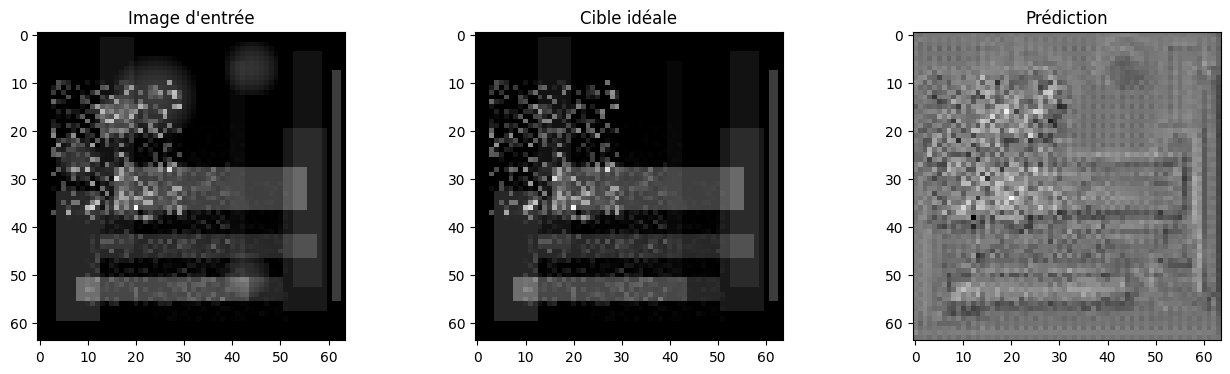

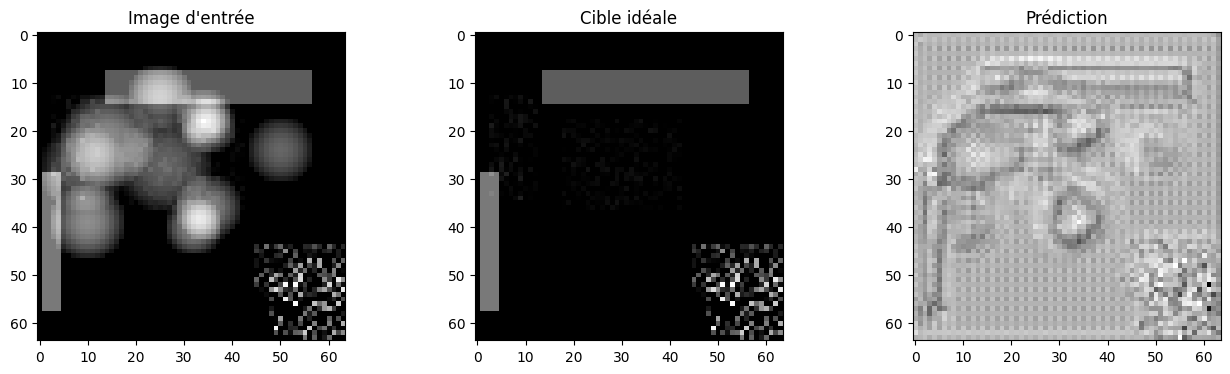

In [ ]:
model.eval()
with torch.no_grad():
    test_inputs, test_targets = gen_dr_test(6)
    test_inputs_tensor = torch.tensor(test_inputs, dtype=torch.float32).to(device)
    predictions = model(test_inputs_tensor)
    print(predictions.shape)

for i in range(6):
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 3, 1)
    plt.title("Image d'entrée")
    plt.imshow(test_inputs[i, 0, :, :], cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title("Cible idéale")
    plt.imshow(test_targets[i, 0, :, :], cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Prédiction")
    plt.imshow(predictions[i, 0].cpu().numpy(), cmap='gray')

    plt.show()

**Q3 (Bonus)** Proposez une méthode simple pour améliorer les performances.

Sur le jeu de test, j'observe que les prédictions du modèle sont nettement moins bonnes que sur les données générées par gen_dr_train. Cela montre que le modèle s'est sur-adapté à la distribution spécifique des données d'entraînement et ne parvient pas à généraliser sur un domaine différent.

Pour améliorer cette situation, je propose une solution

Modifier manuellement le dataset
Une autre approche consisterait à modifier manuellement le dataset d'entraînement : par exemple, supprimer certains cercles ou rectangles, ou encore fusionner deux ou trois images pour augmenter la densité d'information. Cela permettrait de créer un jeu de données plus varié et potentiellement plus représentatif des conditions rencontrées lors du test.

\

---

\

**Exercice 4** Un article important

Parcourir rapidement l'article : https://arxiv.org/abs/1505.04597.
Préciser :
- la nature du problème de Machine Learning abordé.
- quelles méthodes d'augmentation de données sont utilisées.
- l'origine du déséquilibre entre les classes cibles et la façon dont elle il est traité (de manière synthétique).

L'article U-Net traite du problème de segmentation d'images en contexte biomédical, c'est-à-dire une classification pixel par pixel (segmentation sémantique) pour identifier, par exemple, les cellules ou leurs membranes dans des images.

Pour compenser le nombre très limité d'images annotées, l'approche repose sur une forte augmentation de données. Les méthodes d'augmentation utilisées incluent notamment des déformations élastiques aléatoires, qui simulent des déformations réalistes du tissu, ainsi que des transformations géométriques telles que des translations, rotations et variations d'intensité.

Le déséquilibre entre les classes cibles provient du fait que les objets d'intérêt (cellules ou membranes) occupent souvent une fraction bien moindre de l'image par rapport au fond. Pour y remédier, une carte de pondération des pixels est pré-calculée, attribuant un poids plus élevé aux pixels des classes minoritaires et, en particulier, aux zones de séparation entre objets adjacents. Cette approche permet d'inciter le réseau à mieux apprendre la distinction entre les objets proches ou se touchant.